# PAIRS TRADING PROJECT

[*********************100%***********************]  2 of 2 completed


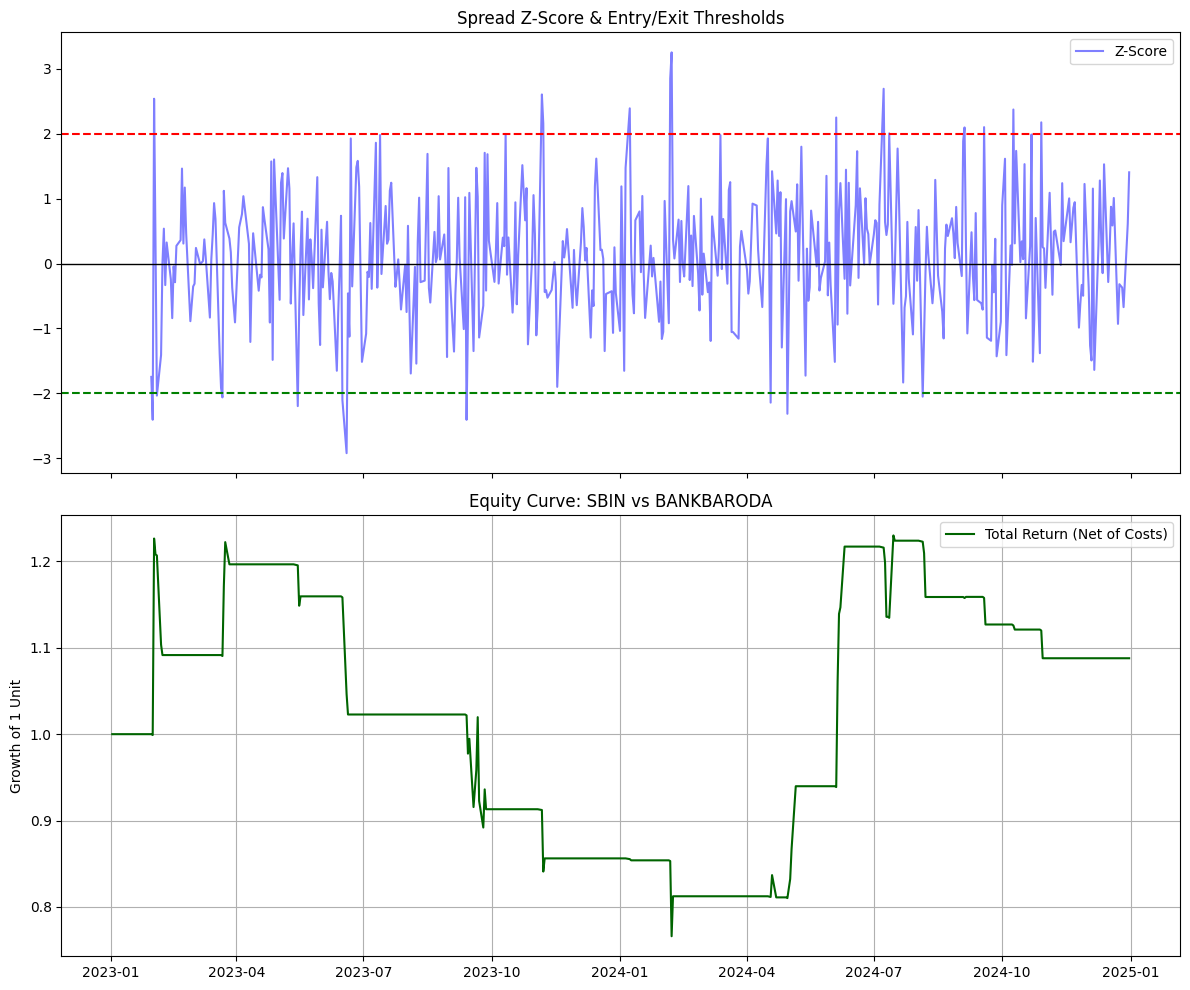

Final Strategy Return: 8.79%
Annualized Sharpe Ratio: 0.29


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# 1. Setup and Data Download
tickers = ['SBIN.NS', 'BANKBARODA.NS']
data = yf.download(tickers, start="2023-01-01", end="2025-01-01", auto_adjust=True)['Close']

# 2. Kalman Filter Implementation
# This estimates the hedge ratio (slope) between the two stocks dynamically
def kalman_filter_hedge_ratio(y, x):
    obs_mat = np.vstack([x, np.ones(len(x))]).T[:, np.newaxis]
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=np.eye(2) * 0.01)
    state_means, _ = kf.filter(y.values)
    return state_means[:, 0] # Returns the dynamic beta

# Calculate dynamic hedge ratio
beta = kalman_filter_hedge_ratio(data['SBIN.NS'], data['BANKBARODA.NS'])
data['spread'] = data['SBIN.NS'] - (beta * data['BANKBARODA.NS'])

# 3. Z-Score and Signal Generation
window = 20
data['mean'] = data['spread'].rolling(window).mean()
data['std'] = data['spread'].rolling(window).std()
data['zscore'] = (data['spread'] - data['mean']) / data['std']

# Define Positions
data['position'] = 0
current_pos = 0
for i in range(len(data)):
    z = data['zscore'].iloc[i]
    if z > 2:
        current_pos = -1 # Short the spread
    elif z < -2:
        current_pos = 1  # Long the spread
    elif abs(z) < 0.5:
        current_pos = 0  # Exit at mean
    data.iloc[i, data.columns.get_loc('position')] = current_pos

# 4. Performance Calculation (Accounting for Costs)
# Cost of 0.1% per trade (entry and exit)
transaction_cost = 0.001 

# Portfolio Return Calculation
data['s_ret'] = data['SBIN.NS'].pct_change()
data['b_ret'] = data['BANKBARODA.NS'].pct_change()

# Combined spread return
data['port_ret'] = data['position'].shift(1) * (
    data['s_ret'] - beta * data['b_ret']
)


# Apply transaction costs whenever position changes
data['trades'] = data['position'].diff().fillna(0).abs()
data['net_ret'] = data['port_ret'] - (data['trades'] * transaction_cost)

# Cumulative Returns
data['cum_ret'] = (1 + data['net_ret'].fillna(0)).cumprod()

# 5. Visualizing the Spread and Strategy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot Z-Score and Signals
ax1.plot(data['zscore'], label='Z-Score', color='blue', alpha=0.5)
ax1.axhline(2, color='red', linestyle='--')
ax1.axhline(-2, color='green', linestyle='--')
ax1.axhline(0, color='black', lw=1)
ax1.set_title('Spread Z-Score & Entry/Exit Thresholds')
ax1.legend()

# Plot Cumulative Returns
ax2.plot(data['cum_ret'], label='Total Return (Net of Costs)', color='darkgreen')
ax2.set_title('Equity Curve: SBIN vs BANKBARODA')
ax2.set_ylabel('Growth of 1 Unit')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Print Final Statistics
total_return = (data['cum_ret'].iloc[-1] - 1) * 100
sharpe = (data['net_ret'].mean() / data['net_ret'].std()) * np.sqrt(252)
print(f"Final Strategy Return: {total_return:.2f}%")
print(f"Annualized Sharpe Ratio: {sharpe:.2f}")